# Video Clustering Analysis
## Goals
to create cluster of video that has similar content or part of video. Ideas is to generate sequence of images from the video, then perform the image clustering analysis on those images

## Test Dataset
Grab the youtube videos based on daily trending videos on youtube-trend videos. Each days about 1000's of videos is recorded as trending videos

## Ideas 
1. Grab the videos
2. cast or explode into series of images, around 30 images per minutes
3. maintain link between images and videos
4. extract features
5. create images vector
6. run the clustering algos


### Function to extract images from video
calculating the frame rate based on given video file.



In [1]:
import os
import logging
import imageio
from moviepy.editor import VideoFileClip

def video_to_images(video_path, output_directory, images_per_minute=1):
    result_array = []
    
    try:
        # Create output directory if it does not exist
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Load the video file
        video = VideoFileClip(video_path)

        # Extract filename without extension
        filename_prefix = os.path.splitext(os.path.basename(video_path))[0]

        # Calculate the total number of frames in the video
        total_frames = int(video.duration * video.fps)
        print('Total frame is %s' % str(total_frames))
        print('Video duration is %s' % str(video.duration))

        # Check if total_frames is zero
        if total_frames == 0:
            print(f"Error: Video '{os.path.basename(video_path)}' has no frames.")
            return result_array

        # Calculate the frame rate based on the number of images per minute
        if video.duration < 60:  # If the video duration is less than 1 minute
            frame_rate = ( total_frames  / video.duration ) # Extract all frames
        else:
            frame_rate = ( total_frames  / video.duration )

        print('Frame rate is %s' % str(int(frame_rate)))

        # Extract frames from the video
        for i, frame in enumerate(video.iter_frames(fps=frame_rate)):
            # Check if the frame index is a multiple of the frame rate
            if i % int(frame_rate*(60/images_per_minute)) == 0:
                # Save each frame as an image file with prefix
                output_file_image = f"{filename_prefix}_frameno_{i:04d}.jpg"
                frame_path = os.path.join(output_directory, output_file_image)
                imageio.imwrite(frame_path, frame)
                
                # Append information about the processed image to the result array
                result_array.append({
                    'video_filename': os.path.basename(video_path),
                    'total_frames': total_frames,
                    'video_duration': video.duration,
                    'frame_rate': frame_rate,
                    'frame_number': i,
                    'output_file_image' : output_file_image,
                    'cluster_no' : ''
                })

        print(f"Video '{os.path.basename(video_path)}' converted to images successfully in '{output_directory}'.")
        print(f"Extracted {((video.duration * images_per_minute // 60)+1)} frames ({images_per_minute} frames per minute).")
        
        return result_array

    except Exception as e:
        error_message = f"Error converting video '{video_path}' to images: {e}"
        print(error_message)
        # Log the error
        logging.error(error_message)
        return result_array


In [2]:
import os
import re
import matplotlib.pyplot as plt
from PIL import Image

def view_images(video_filename):
    try:
        # Extract folder and filename without extension
        folder, filename = os.path.split(video_filename)
        filename_prefix = os.path.splitext(filename)[0]

        # Get list of image files
        image_files = [file for file in os.listdir(folder) if file.startswith(filename_prefix)]

        if not image_files:
            print("No image files found.")
            return

        # Sort the image files based on their indices
        image_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

        # Display images
        for image_file in image_files:
            image_path = os.path.join(folder, image_file)
            
            # Check if the file is a valid image
            try:
                Image.open(image_path)
            except IOError:
                print(f"Skipping non-image file: {image_file}")
                continue
            
            img = plt.imread(image_path)
            plt.imshow(img)
            plt.title(image_file)
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"Error viewing images: {e}")


In [3]:
# Check if the folder exists
# 

folder = '/home/jup_user/multipool/ai-case-study/video-data'
video_process = []

if not os.path.exists(folder):
    print(f"Folder '{folder}' does not exist.")

# Iterate through files in the folder
for file in os.listdir(folder):
    if file.endswith(".mp4"):
        # Print the full path of the MP4 file
        print('Processing %s' % os.path.join(folder, file))
        # print(folder)
        video_process.append(video_to_images(os.path.join(folder, file),output_directory='/home/jup_user/multipool/ai-case-study/video-data/img', images_per_minute=10))


Processing /home/jup_user/multipool/ai-case-study/video-data/527C74YLV20.mp4
Total frame is 8992
Video duration is 300.04
Frame rate is 29
Video '527C74YLV20.mp4' converted to images successfully in '/home/jup_user/multipool/ai-case-study/video-data/img'.
Extracted 51.0 frames (10 frames per minute).
Processing /home/jup_user/multipool/ai-case-study/video-data/6VfxHXc6Scg.mp4
Total frame is 1290
Video duration is 51.61
Frame rate is 24
Video '6VfxHXc6Scg.mp4' converted to images successfully in '/home/jup_user/multipool/ai-case-study/video-data/img'.
Extracted 9.0 frames (10 frames per minute).
Processing /home/jup_user/multipool/ai-case-study/video-data/_W3QvIJ3zrw.mp4
Total frame is 26676
Video duration is 1111.52
Frame rate is 23
Video '_W3QvIJ3zrw.mp4' converted to images successfully in '/home/jup_user/multipool/ai-case-study/video-data/img'.
Extracted 186.0 frames (10 frames per minute).
Processing /home/jup_user/multipool/ai-case-study/video-data/0SFtqr8T7Tc.mp4
Total frame is 1

### Feature Vector
Now, we try to create feature vector of all images extracted

In [4]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from sklearn.metrics.pairwise import cosine_similarity

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#
# extracting feature from image files
#
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)

    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)

    # return feature vector
    return features

#
# function to calculate clusters
#
def cluster(filePaths, features, threshold=0.9):
    features = features.reshape(-1,4096)
    simMatrix = cosine_similarity(features)
    clusters = {}
    for i in range(len(features)):
        dupIdx = list(np.where(simMatrix[i] > threshold)[0])
        # The similarity matrix will include comparisons of items with themselves, which will always 
        # result in a similarity of 1.0 (100%) and is redundant, so we ignore those
        if len(dupIdx) > 1:
            curCluster, clusterMatch = list(dupIdx), None
            # The first time an image is found to be in any given cluster, we log the entire cluster, 
            # so subsequent checks of other images from the same cluster would result in duplicated clusters.
            # Check for that here
            for cIdx in clusters:
                if curCluster[0] in clusters[cIdx]:
                    clusterMatch = cIdx
                    break
            # If the current cluster didn't match any existing ones, create/log it
            if clusterMatch == None: clusters[len(clusters)] = curCluster
    # Resolve file indices back to file paths
    for cIdx in clusters: clusters[cIdx] = [filePaths[x] for x in clusters[cIdx]]
    return clusters


2024-04-01 17:52:55.269841: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 17:52:55.272434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:52:55.321205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:52:55.322612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 17:52:56.124025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [13]:
import pickle
import numpy as np
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)

# Specify the path to the new directory
new_directory = '/home/jup_user/multipool/ai-case-study/video-data/img'

# Change the current working directory
os.chdir(new_directory)

# prepare base model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

data = {}
p = "/home/jup_user/multipool/ai-case-study/video-data/img/wb.pickle"

# loop through each image in the dataset
for video_file in video_process:
    # print(video_file)
    for image_file in video_file:
        print(image_file['output_file_image'])
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image_file['output_file_image'],model)
            data[image_file['output_file_image']] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            with open(p,'wb') as file:
                pickle.dump(data,file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

Current directory: /home/jup_user/multipool/ai-case-study
527C74YLV20_frameno_0000.jpg
1/1 [==============================] - 0s 223ms/step
527C74YLV20_frameno_0179.jpg
1/1 [==============================] - 0s 84ms/step
527C74YLV20_frameno_0358.jpg
1/1 [==============================] - 0s 70ms/step
527C74YLV20_frameno_0537.jpg
1/1 [==============================] - 0s 60ms/step
527C74YLV20_frameno_0716.jpg
1/1 [==============================] - 0s 59ms/step
527C74YLV20_frameno_0895.jpg
1/1 [==============================] - 0s 65ms/step
527C74YLV20_frameno_1074.jpg
1/1 [==============================] - 0s 61ms/step
527C74YLV20_frameno_1253.jpg
1/1 [==============================] - 0s 59ms/step
527C74YLV20_frameno_1432.jpg
1/1 [==============================] - 0s 60ms/step
527C74YLV20_frameno_1611.jpg
1/1 [==============================] - 0s 62ms/step
527C74YLV20_frameno_1790.jpg
1/1 [==============================] - 0s 60ms/step
527C74YLV20_frameno_1969.jpg
1/1 [================

In [14]:
print(feat)
# another method of clustering based on CSI
clus_new = cluster(filenames, feat, threshold=0.8)

[[0.         0.         1.5199001  ... 0.         0.         4.7429175 ]
 [0.         0.         0.         ... 0.         0.         1.3209112 ]
 [1.0899315  0.         0.         ... 0.         0.         0.8406786 ]
 ...
 [0.         0.         0.         ... 0.         0.         1.006755  ]
 [0.         0.         0.         ... 0.         0.         1.229309  ]
 [0.         0.         0.         ... 0.         0.37629429 1.0742984 ]]


### How are we going to record the result?

Table of:
 1. cluster number
 2. id, video id
 3. frame no,
 4. timestamp --> calculated from (frame# / total frame) * frame rate = second position of image
 
bytes per day of videos 
419.103.505
- about 22-25 videos
- max video duration 20 min
- for video larger than 20 min, take first 5 min

bytes per day of image sampling (5 image/minute)
36.308.536

In [15]:
# iterate over video_process
for video in video_process:
    # print(video)
    for images in video:
        print(images['output_file_image'])
        file_to_find = images['output_file_image']
        
        for cluster in clus_new:
            # print(type(clus_new[cluster]))
            try:
                index = clus_new[cluster].index(file_to_find)
                print('found in %s' % index)
                images['cluster_no'] = index
            except ValueError:
                i = 0

527C74YLV20_frameno_0000.jpg
527C74YLV20_frameno_0179.jpg
found in 0
527C74YLV20_frameno_0358.jpg
found in 0
527C74YLV20_frameno_0537.jpg
found in 1
527C74YLV20_frameno_0716.jpg
found in 2
527C74YLV20_frameno_0895.jpg
found in 3
527C74YLV20_frameno_1074.jpg
found in 4
527C74YLV20_frameno_1253.jpg
found in 5
527C74YLV20_frameno_1432.jpg
found in 6
527C74YLV20_frameno_1611.jpg
found in 7
527C74YLV20_frameno_1790.jpg
found in 8
527C74YLV20_frameno_1969.jpg
found in 9
527C74YLV20_frameno_2148.jpg
found in 10
527C74YLV20_frameno_2327.jpg
found in 11
527C74YLV20_frameno_2506.jpg
found in 12
527C74YLV20_frameno_2685.jpg
found in 1
527C74YLV20_frameno_2864.jpg
found in 13
527C74YLV20_frameno_3043.jpg
found in 2
527C74YLV20_frameno_3222.jpg
found in 3
527C74YLV20_frameno_3401.jpg
found in 4
527C74YLV20_frameno_3580.jpg
found in 5
527C74YLV20_frameno_3759.jpg
found in 0
527C74YLV20_frameno_3938.jpg
found in 1
527C74YLV20_frameno_4117.jpg
found in 14
527C74YLV20_frameno_4296.jpg
found in 15
527C7

In [17]:
import pandas as pd

def convert_to_integer(value):
    if len(str(value)) == 0:  # Check if the value is a zero-length string
        return -1
    else:
        return int(value)
        
# flatten the video_process list
columns_dict = {
    'video_filename' : str, 
    'total_frames' : int, 
    'video_duration' : int,
    'frame_rate' : int,
    'frame_number' : int,
    'output_file_image' : str,
    'cluster_no' : int
}
df_res = pd.DataFrame(columns=columns_dict.keys())

for video in video_process:
    for image in video:
        print((image))
        df_res.loc[len(df_res)] = image

# Assuming df is your DataFrame and 'column_name' is the column you want to convert
df_res['cluster_no'] = df_res['cluster_no'].apply(convert_to_integer)

{'video_filename': '527C74YLV20.mp4', 'total_frames': 8992, 'video_duration': 300.04, 'frame_rate': 29.969337421677107, 'frame_number': 0, 'output_file_image': '527C74YLV20_frameno_0000.jpg', 'cluster_no': ''}
{'video_filename': '527C74YLV20.mp4', 'total_frames': 8992, 'video_duration': 300.04, 'frame_rate': 29.969337421677107, 'frame_number': 179, 'output_file_image': '527C74YLV20_frameno_0179.jpg', 'cluster_no': 0}
{'video_filename': '527C74YLV20.mp4', 'total_frames': 8992, 'video_duration': 300.04, 'frame_rate': 29.969337421677107, 'frame_number': 358, 'output_file_image': '527C74YLV20_frameno_0358.jpg', 'cluster_no': 0}
{'video_filename': '527C74YLV20.mp4', 'total_frames': 8992, 'video_duration': 300.04, 'frame_rate': 29.969337421677107, 'frame_number': 537, 'output_file_image': '527C74YLV20_frameno_0537.jpg', 'cluster_no': 1}
{'video_filename': '527C74YLV20.mp4', 'total_frames': 8992, 'video_duration': 300.04, 'frame_rate': 29.969337421677107, 'frame_number': 716, 'output_file_ima

## Explore the dataframe result
create all histogram on every fields and so on 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

def perform_eda(frames_list):
    # Convert the list of dictionaries to a pandas DataFrame
    df = frames_list #pd.DataFrame(frames_list)

    # Display basic information about the DataFrame
    print("DataFrame Information:")
    print(df.info())
    print()

    # Summary statistics for numerical columns
    print("Summary Statistics:")
    print(df.describe())
    print()

    # Plot histogram of frame numbers
    plt.figure(figsize=(8, 6))
    df['frame_number'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Frame Numbers')
    plt.xlabel('Frame Number')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot histogram of cluster numbers
    plt.figure(figsize=(8, 6))
    df['cluster_no'].plot(kind='hist', bins=10, color='salmon', edgecolor='black')
    plt.title('Histogram of Cluster Numbers')
    plt.xlabel('Cluster Number')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot distribution of video durations
    plt.figure(figsize=(8, 6))
    df['video_duration'].plot(kind='hist', bins=20, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Video Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Check for missing values
    print("Missing Values:")
    print(df.isnull().sum())
    print()

    # Visualize the distribution of cluster numbers using a bar plot
    plt.figure(figsize=(8, 6))
    df['cluster_no'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Distribution of Cluster Numbers')
    plt.xlabel('Cluster Number')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

    # Count the number of rows for each unique value in 'cluster_no' column
    cluster_counts = df['cluster_no'].value_counts()
    
    # Plot bar chart
    cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Rows')
    plt.title('Number of Rows in Each Cluster')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # Calculate the frequency of each cluster
    cluster_counts = df['cluster_no'].value_counts()
    
    # Plot treemap
    plt.figure(figsize=(10, 6))
    squarify.plot(sizes=cluster_counts.values, label=cluster_counts.index, alpha=0.7)
    plt.axis('off')
    plt.title('Treemap of Cluster Numbers')
    plt.show()    

    # Display count of unique video filenames
    unique_filenames_count = df['video_filename'].nunique()
    print("Count of Unique Video Filenames:", unique_filenames_count)

In [19]:
# perform_eda(df_res)
# Calculate maximum and minimum values of 'cluster_no' column
max_cluster = df_res['cluster_no'].max()
min_cluster = df_res['cluster_no'].min()

print("Maximum cluster_no:", max_cluster)
print("Minimum cluster_no:", min_cluster)

Maximum cluster_no: 128
Minimum cluster_no: -1


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 0 to 313
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_filename     314 non-null    object 
 1   total_frames       314 non-null    int64  
 2   video_duration     314 non-null    float64
 3   frame_rate         314 non-null    float64
 4   frame_number       314 non-null    int64  
 5   output_file_image  314 non-null    object 
 6   cluster_no         314 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 19.6+ KB
None

Summary Statistics:
       total_frames  video_duration  frame_rate  frame_number  cluster_no
count    314.000000      314.000000  314.000000    314.000000  314.000000
mean   18907.754777      763.243089   26.118076   9420.754777   28.328025
std     9643.708395      428.081473    2.813486   7814.160919   38.582769
min      990.000000       33.020000   23.999568      0.000000

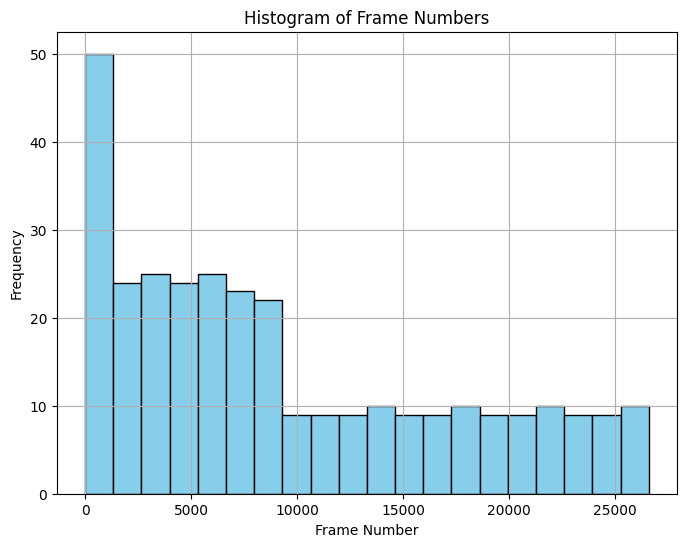

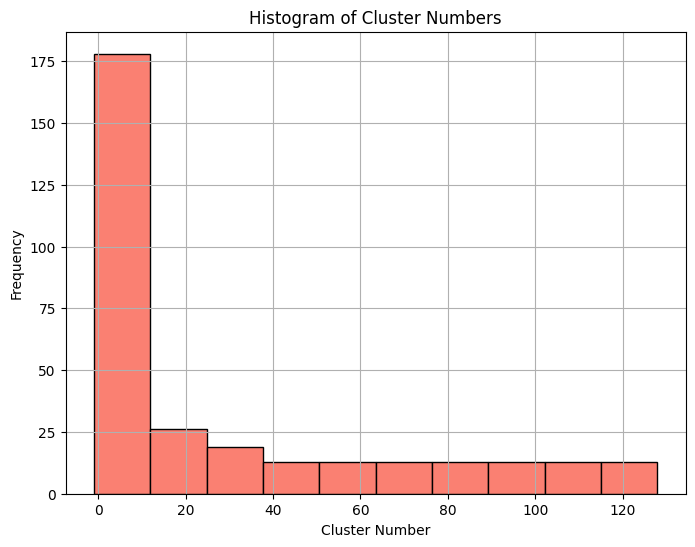

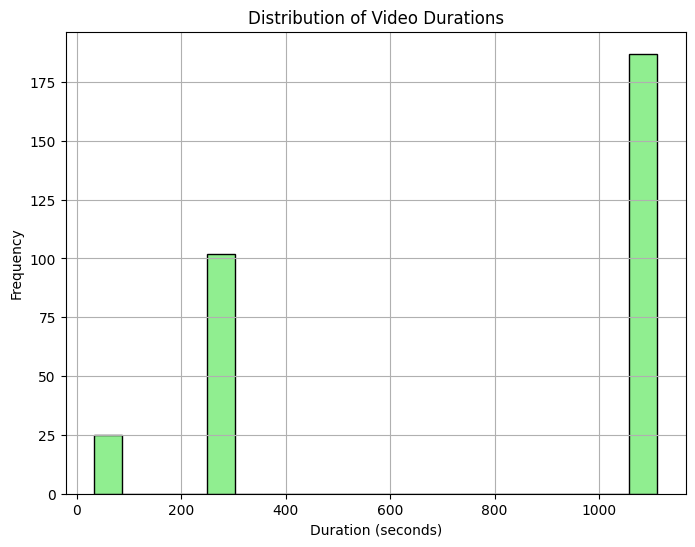

Missing Values:
video_filename       0
total_frames         0
video_duration       0
frame_rate           0
frame_number         0
output_file_image    0
cluster_no           0
dtype: int64



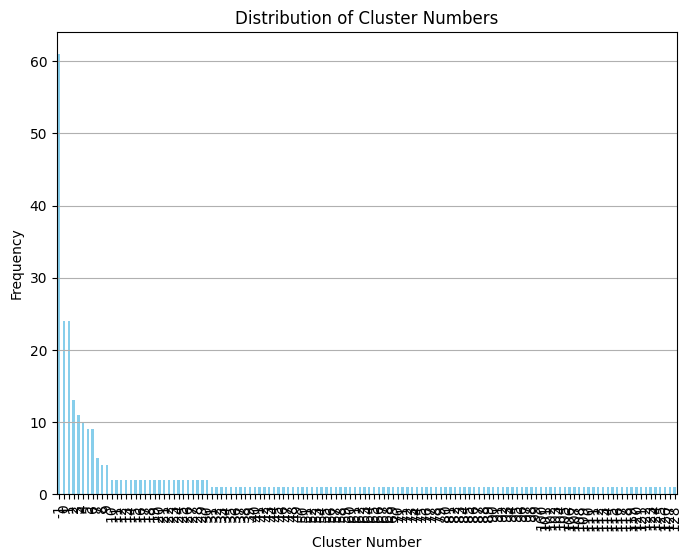

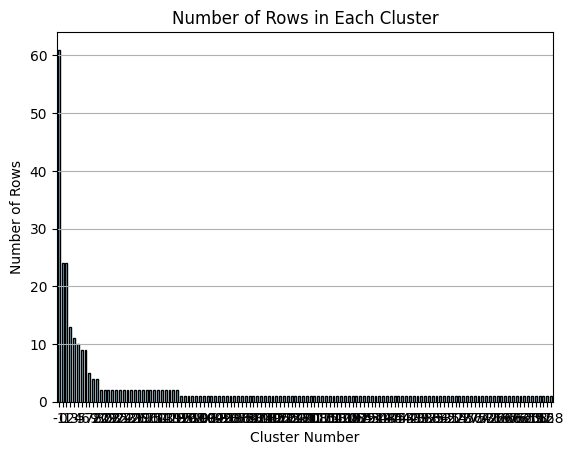

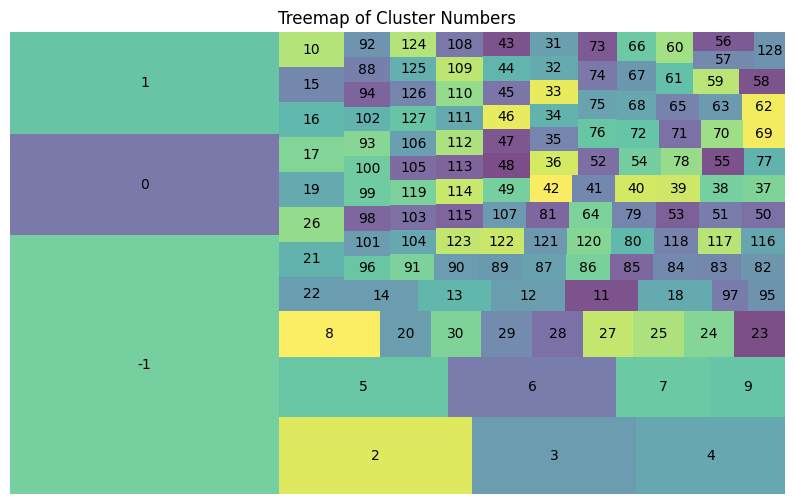

Count of Unique Video Filenames: 6


In [20]:
perform_eda(df_res)